In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn  
import torch.optim as optim  
import torchvision.transforms as transforms 
import torchvision
import os
from skimage import io
from torch.utils.data import (Dataset,DataLoader) 

In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_directory = '/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/training-c.csv'
df = pd.read_csv(main_directory, sep=",")
print(df)

         filename           original filename  ...  contributing team  database name
0      c00000.png  Scan_280_digit_6_num_7.png  ...   Buet_Backpropers     training-c
1      c00001.png   Scan_29_digit_1_num_1.png  ...   Buet_Backpropers     training-c
2      c00002.png  Scan_131_digit_3_num_1.png  ...   Buet_Backpropers     training-c
3      c00003.png  Scan_160_digit_2_num_2.png  ...   Buet_Backpropers     training-c
4      c00004.png  Scan_202_digit_7_num_0.png  ...   Buet_Backpropers     training-c
...           ...                         ...  ...                ...            ...
24293  c24293.png  Scan_167_digit_3_num_4.png  ...   Buet_Backpropers     training-c
24294  c24294.png  Scan_174_digit_2_num_8.png  ...   Buet_Backpropers     training-c
24295  c24295.png  Scan_152_digit_7_num_4.png  ...   Buet_Backpropers     training-c
24296  c24296.png  Scan_123_digit_2_num_2.png  ...   Buet_Backpropers     training-c
24297  c24297.png    Scan_2_digit_7_num_6.png  ...   Buet_Backpro

In [ ]:
df.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [ ]:
df = df.drop(['original filename','scanid','database name original', 'contributing team','database name'], axis = 1)

In [ ]:
df.to_csv('/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/modified.csv',index = False)

In [ ]:
batch_size = 100
input_dim = 100*100 
num_hidden = 300
output_dim = 10
learning_rate = 0.01 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class HandWrittenNumberRecognition(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [ ]:
transform_Img = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(100),
                                    transforms.ToTensor()])

In [ ]:
dataset = HandWrittenNumberRecognition(
    csv_file="/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/modified.csv",
    root_dir="/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/training-c",
    transform=transform_Img
)

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [19438,4860])
print(len(train_dataset))
print(len(test_dataset))

19438
4860


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
      
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.sig_1 = nn.Sigmoid()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
       
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.sig_1(out)

        out  = self.linear_3(out)
        out = self.relu_2(out)
        
        probas  = self.linear_out(out)
        return probas



model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
iter = 0
total_loss = []
iteration = []
correctly_classified_PerEpoch = []
accuracy_perEpoch = []
num_of_epoch = []
for epoch in range(20):
    print('Epoch: ',epoch+1)
    num_of_epoch.append(epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 100*100).to(device)

        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        print('Iteration no: ',iter)
        if iter % 150 == 0:
            print('loss in iteration ',iter,'= ',loss.item())
            total_loss.append(loss.item())
            iteration.append(iter)

    correct = 0
    total = 0
    for images, labels in test_loader:
          
          images = images.view(-1,100*100).to(device)
          outputs = model(images)
 
          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)
 
          if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum() 
          else:
                correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    accuracy_perEpoch.append(accuracy)
    correctly_classified_PerEpoch.append(correct.item())
    print('Total Data: {}.  CorrectlyPredicted: {}.'.format(total,correct))
    print('Accuracy in epoch ',epoch+1,'=',accuracy)

Epoch:  1
Iteration no:  1
Iteration no:  2
Iteration no:  3
Iteration no:  4
Iteration no:  5
Iteration no:  6
Iteration no:  7
Iteration no:  8
Iteration no:  9
Iteration no:  10
Iteration no:  11
Iteration no:  12
Iteration no:  13
Iteration no:  14
Iteration no:  15
Iteration no:  16
Iteration no:  17
Iteration no:  18
Iteration no:  19
Iteration no:  20
Iteration no:  21
Iteration no:  22
Iteration no:  23
Iteration no:  24
Iteration no:  25
Iteration no:  26
Iteration no:  27
Iteration no:  28
Iteration no:  29
Iteration no:  30
Iteration no:  31
Iteration no:  32
Iteration no:  33
Iteration no:  34
Iteration no:  35
Iteration no:  36
Iteration no:  37
Iteration no:  38
Iteration no:  39
Iteration no:  40
Iteration no:  41
Iteration no:  42
Iteration no:  43
Iteration no:  44
Iteration no:  45
Iteration no:  46
Iteration no:  47
Iteration no:  48
Iteration no:  49
Iteration no:  50
Iteration no:  51
Iteration no:  52
Iteration no:  53
Iteration no:  54
Iteration no:  55
Iteration

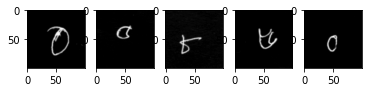

In [ ]:
import matplotlib
for images, labels in test_loader:
    break
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(100,100), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
for images, labels in test_loader:
    break
for i in range(11,18):
   predictions = model(images[i].view(-1, 100*100).to(device))
   predictions = torch.argmax(predictions, dim=1)
   print('Predicted labels', predictions.cpu().numpy())
   print(predictions)
   print(labels[i])

Predicted labels [0]
tensor([0], device='cuda:0')
tensor(8)
Predicted labels [0]
tensor([0], device='cuda:0')
tensor(2)
Predicted labels [0]
tensor([0], device='cuda:0')
tensor(4)
Predicted labels [0]
tensor([0], device='cuda:0')
tensor(7)
Predicted labels [0]
tensor([0], device='cuda:0')
tensor(3)
Predicted labels [0]
tensor([0], device='cuda:0')
tensor(8)
Predicted labels [0]
tensor([0], device='cuda:0')
tensor(7)


In [ ]:
print('loss count after every 750 iteration: ',total_loss)
print('iteration count: ',iteration)
print('Correctly classfied per epoch: ',correctly_classified_PerEpoch)
print('accuracy per epoch: ',accuracy_perEpoch)
print('Epoch list: ',num_of_epoch)

loss count after every 750 iteration:  [2.2972731590270996, 2.2967774868011475, 2.3036253452301025, 2.3004636764526367, 2.3035833835601807, 2.304354667663574, 2.302912950515747, 2.295151472091675, 2.2997775077819824, 2.3104653358459473, 2.305119276046753, 2.2983264923095703, 2.316904306411743, 2.301027774810791, 2.302971839904785, 2.307598114013672, 2.3011839389801025, 2.301783561706543, 2.299013137817383, 2.3036391735076904, 2.302154064178467, 2.3054141998291016, 2.302257776260376, 2.2989821434020996, 2.299560308456421, 2.3056514263153076]
iteration count:  [150, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500, 1650, 1800, 1950, 2100, 2250, 2400, 2550, 2700, 2850, 3000, 3150, 3300, 3450, 3600, 3750, 3900]
Correctly classfied per epoch:  [470, 480, 443, 483, 480, 480, 470, 519, 443, 483, 464, 483, 480, 470, 538, 478, 443, 696, 656, 483]
accuracy per epoch:  [9.670781893004115, 9.876543209876543, 9.11522633744856, 9.938271604938272, 9.876543209876543, 9.876543209876543, 9.67078189300411

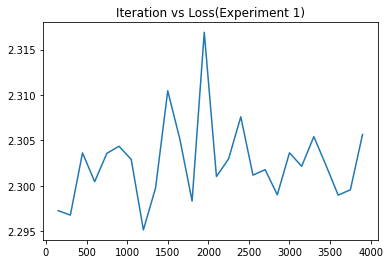

In [ ]:
plt.plot(iteration,total_loss)
plt.title('Iteration vs Loss(Experiment 1)')
plt.show()

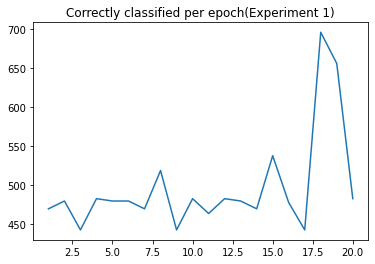

In [ ]:
plt.plot(num_of_epoch,correctly_classified_PerEpoch)
plt.title('Correctly classified per epoch(Experiment 1)')
plt.show()

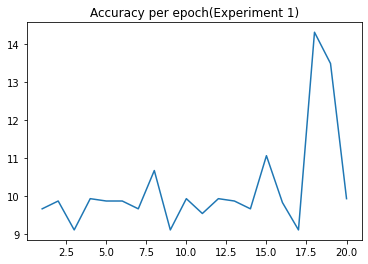

In [ ]:
plt.plot(num_of_epoch,accuracy_perEpoch)
plt.title('Accuracy per epoch(Experiment 1)')
plt.show()

In [ ]:
root_path = '/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/ALLCOVERED'
save_model = True

if save_model is True:
    torch.save(model.state_dict(), root_path + '170104027_Exp2_1.pkl') 